In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

from random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import contingency_matrix

from statistics import mean

# Загрузка данных варианта

In [2]:
specter = np.load('12.npy')
mask = np.load('12_mask.npy')
X = []
height = specter.shape[0]
width = specter.shape[1]
OP = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1,2)


for idx in OP:
    X.append(specter[idx[0], idx[1],::])
    
X = np.array(X, copy=False)

mms = MinMaxScaler()
X = mms.fit_transform(X)

# Вспомогательные функции

In [3]:
def euclidean(x, y):
    diff = x - y
    dist_2 = np.sum(diff * diff, axis=-1)
    return np.sqrt(dist_2)

In [4]:
def manhattan(x, y):
    diff = x - y
    return np.sum(np.abs(diff), axis =1)

In [5]:
def chebyshev(x,y):
    diff = x - y
    return np.max(np.abs(diff), axis = 1)

In [6]:
def cluster_resp(distances):
    d_exp = np.exp(-distances)
    return d_exp / np.sum(d_exp, axis=1, keepdims=True)

In [7]:
def loss(X, M, R, distance):
    loss = 0
    for k in range(len(M)):
        d = distance(X, M[k])
        loss += np.sum(R[:,k] * (d * d))
    return loss

# Реализация k-means и soft k-means

In [8]:
def k_means(X, K, distance, max_iter):
    N, D = X.shape
    L = np.zeros(N)
    M = np.zeros((K, D))
    
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    M_prev = M.copy()
    for i in range(max_iter):
        dists = []

        for k in range(K):
            dists += [distance(X, M[k]).reshape(-1, 1)]
    
        dists = np.hstack(dists) 
        L = np.argmin(dists, axis=1)

        for k in range(K):
            M[k] = X[L==k].mean(axis=0)
            
        if np.allclose(M, M_prev):
            break
        else:
            M_prev = M.copy()
   
    return L

In [12]:
def soft_k_means(X, K, distance, max_iter):
    N, D = X.shape
    R = np.zeros((N, K))
    M = np.zeros((K, D))
    losses = []
    
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    for i in range(max_iter):
        dists = []

        for k in range(K):
            dists += [distance(X, M[k]).reshape(-1, 1)]

        dists = np.hstack(dists) 
        
        R = cluster_resp(dists)
        
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()
            
        losses.append(loss(X, M, R, distance))
            
        if len(losses) > 2 and np.abs(losses[-1] - losses[-2]) < 1e-6:
            break
        
    L = np.argmax(R, axis = 1)
    return L

# Проверки

In [10]:
def purity(class_labels, cluster_labels):
    c_m = contingency_matrix(class_labels, cluster_labels)
    return np.sum(np.amax(c_m, axis=0)) / np.sum(c_m)

In [11]:
def DBI(X, cluster_labels):
    n_cluster = len(np.bincount(cluster_labels))
    cluster_k = [X[cluster_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([euclidean(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []

    for i in range(n_cluster):
        for j in range(n_cluster):
            if j != i:
                db.append((variances[i] + variances[j]) / euclidean(centroids[i], centroids[j]))

    return(np.max(db) / n_cluster)

# Сбор статистики

In [29]:
def create_statistic(X, minK, maxK):
    make_df_k_mean = pd.DataFrame()
    make_df_soft_k_mean = pd.DataFrame()
    
    for K in range(minK, maxK+1):
        print("Start for {} nums of clusters".format(K))
        for distance in [euclidean, manhattan, chebyshev]:
            L = k_means(X, K, distance, 10)
            print("Start k-means clusterization with {} distance metric".format(distance.__name__))
            pur = purity(mask, L)
            dbi = DBI(X, L)
            
            k_means_voc = {
                "Nums of clusters": K,
                'Dist metric': distance.__name__,
                'purity': pur,
                'DBI': dbi,
                'labels': L
            }
            make_df_k_mean = make_df_k_mean.append(k_means_voc, ignore_index=True)
            
        for distance in [euclidean, manhattan, chebyshev]:
            L = soft_k_means(X, K, distance, 10)
            print("Start SOFT k-means clusterization with {} distance metric".format(distance.__name__))
            pur = purity(mask, L)
            dbi = DBI(X, L)
            
            soft_k_means_voc = {
                "Nums of clusters": K,
                'Dist metric': distance.__name__,
                'purity': pur,
                'DBI': dbi,
                'labels': L
            }
            make_df_soft_k_mean = make_df_soft_k_mean.append(soft_k_means_voc, ignore_index=True)
            
    return (make_df_k_mean, make_df_soft_k_mean)

In [78]:
dfkm, dfskm = create_statistic(X, 2, 10)

Start for 2 nums of clusters
Start k-means clusterization with euclidean distance metric
Start k-means clusterization with manhattan distance metric
Start k-means clusterization with chebyshev distance metric
Start SOFT k-means clusterization with euclidean distance metric
Start SOFT k-means clusterization with manhattan distance metric
Start SOFT k-means clusterization with chebyshev distance metric
Start for 3 nums of clusters
Start k-means clusterization with euclidean distance metric
Start k-means clusterization with manhattan distance metric
Start k-means clusterization with chebyshev distance metric
Start SOFT k-means clusterization with euclidean distance metric
Start SOFT k-means clusterization with manhattan distance metric
Start SOFT k-means clusterization with chebyshev distance metric


C:\Users\Артем\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Артем\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\Артем\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Start for 4 nums of clusters
Start k-means clusterization with euclidean distance metric
Start k-means clusterization with manhattan distance metric
Start k-means clusterization with chebyshev distance metric
Start SOFT k-means clusterization with euclidean distance metric
Start SOFT k-means clusterization with manhattan distance metric
Start SOFT k-means clusterization with chebyshev distance metric
Start for 5 nums of clusters
Start k-means clusterization with euclidean distance metric
Start k-means clusterization with manhattan distance metric
Start k-means clusterization with chebyshev distance metric
Start SOFT k-means clusterization with euclidean distance metric
Start SOFT k-means clusterization with manhattan distance metric
Start SOFT k-means clusterization with chebyshev distance metric
Start for 6 nums of clusters
Start k-means clusterization with euclidean distance metric
Start k-means clusterization with manhattan distance metric
Start k-means clusterization with chebyshev

# Итоги

### DataFrame со значениями purity и DBI для каждой метрики расстояния и количества кластеров
Выведем два наших DataFrame для *k-means* и *soft k-means* отсортированных по оценке кластеризации.

**Сортировка по оценке PURITY для _k-means_**:

In [79]:
sorted_df_k_means = dfkm.sort_values(by='purity', ascending=False)
sorted_df_k_means

,DBI,Dist metric,Nums of clusters,labels,purity
19,0.145565,manhattan,8.0,"[1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, ...",0.707130
24,0.122363,euclidean,10.0,"[3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, ...",0.707016
16,0.147304,manhattan,7.0,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, ...",0.706852
25,0.124895,manhattan,10.0,"[4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, ...",0.705288
0,0.337881,euclidean,2.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.696289
14,0.179780,chebyshev,6.0,"[5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",0.696289
23,0.165055,chebyshev,9.0,"[4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 1, 3, 4, 4, 4, ...",0.696289
22,0.150951,manhattan,9.0,"[1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, ...",0.696289
21,0.136614,euclidean,9.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.696289
20,0.167066,chebyshev,8.0,"[6, 6, 2, 2, 6, 6, 6, 2, 2, 2, 2, 2, 2, 6, 2, ...",0.696289


**Сортировка по оценке PURITY для _soft k-means_**:

In [80]:
sorted_df_soft_k_means = dfskm.sort_values(by='purity', ascending=False)
sorted_df_soft_k_means

,DBI,Dist metric,Nums of clusters,labels,purity
22,0.153748,manhattan,9.0,"[6, 6, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...",0.704655
0,0.337482,euclidean,2.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.696289
14,NaN,chebyshev,6.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.696289
25,0.140057,manhattan,10.0,"[0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 0, 0, 0, 0, ...",0.696289
24,2.033646,euclidean,10.0,"[1, 1, 5, 5, 5, 1, 5, 5, 5, 4, 4, 5, 1, 1, 1, ...",0.696289
23,NaN,chebyshev,9.0,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",0.696289
21,0.368344,euclidean,9.0,"[6, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 6, 1, ...",0.696289
20,NaN,chebyshev,8.0,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",0.696289
19,0.164893,manhattan,8.0,"[5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 1, 5, 5, 5, ...",0.696289
18,1.489363,euclidean,8.0,"[0, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 5, 5, 0, 5, ...",0.696289


### График отношений DBI/Purity и количества кластеров.

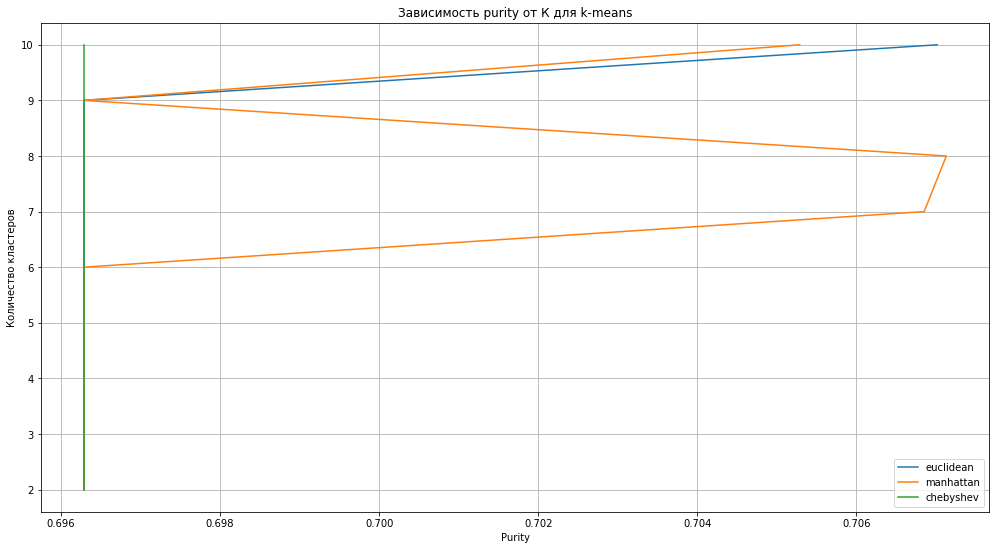

In [81]:
plt.figure(figsize=(17, 9))
plt.title("Зависимость purity от К для k-means") 
plt.xlabel("Purity") 
plt.ylabel("Количество кластеров") 
plt.grid()      
plt.plot(dfkm.loc[dfkm["Dist metric"] == "euclidean", "purity"], dfkm.loc[dfkm["Dist metric"] == "euclidean", "Nums of clusters"], label="euclidean")
plt.plot(dfkm.loc[dfkm["Dist metric"] == "manhattan", "purity"], dfkm.loc[dfkm["Dist metric"] == "manhattan", "Nums of clusters"], label="manhattan")
plt.plot(dfkm.loc[dfkm["Dist metric"] == "chebyshev", "purity"], dfkm.loc[dfkm["Dist metric"] == "chebyshev", "Nums of clusters"], label="chebyshev")
plt.legend()

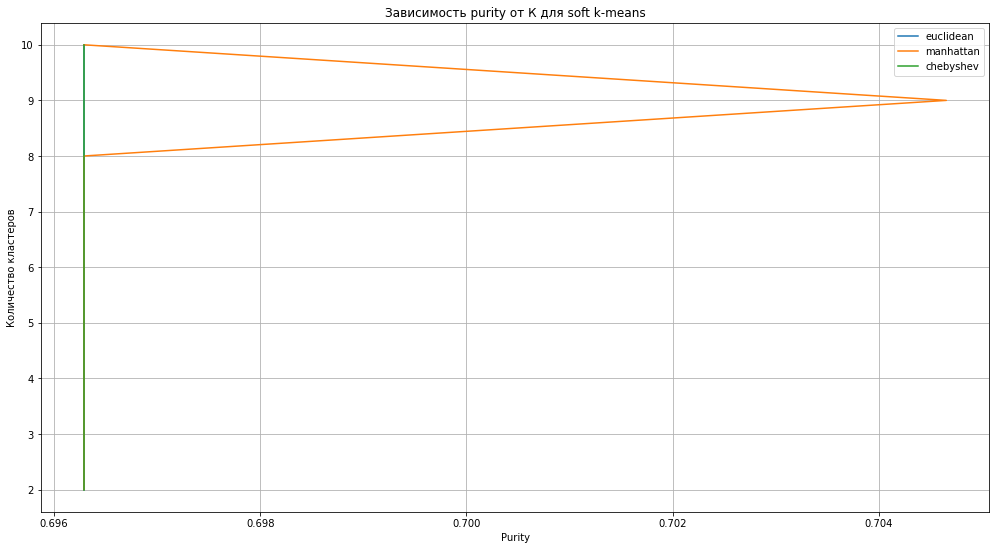

In [82]:
plt.figure(figsize=(17, 9))
plt.title("Зависимость purity от К для soft k-means") 
plt.xlabel("Purity") 
plt.ylabel("Количество кластеров") 
plt.grid()      
plt.plot(dfskm.loc[dfskm["Dist metric"] == "euclidean", "purity"], dfskm.loc[dfskm["Dist metric"] == "euclidean", "Nums of clusters"], label="euclidean")
plt.plot(dfskm.loc[dfskm["Dist metric"] == "manhattan", "purity"], dfskm.loc[dfskm["Dist metric"] == "manhattan", "Nums of clusters"], label="manhattan")
plt.plot(dfskm.loc[dfskm["Dist metric"] == "chebyshev", "purity"], dfskm.loc[dfskm["Dist metric"] == "chebyshev", "Nums of clusters"], label="chebyshev")
plt.legend()

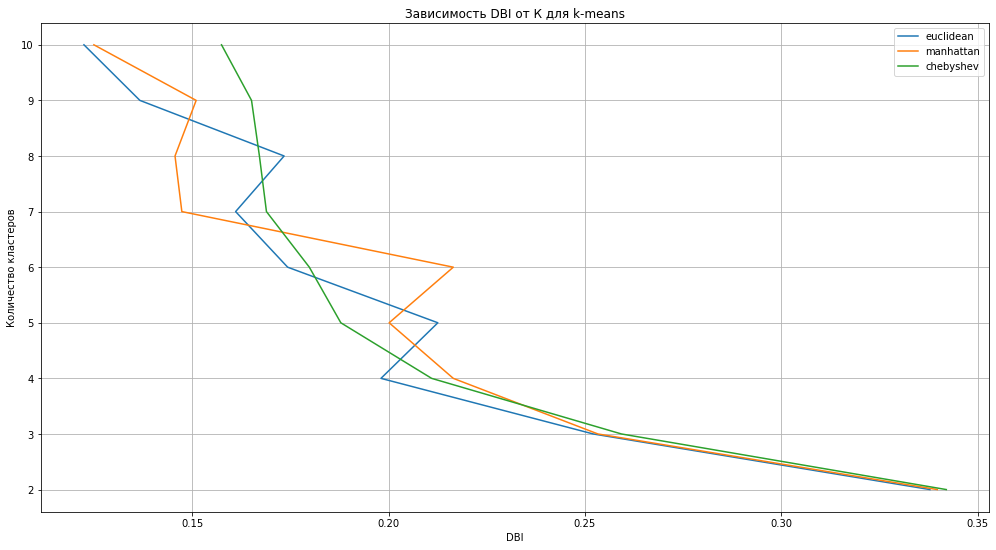

In [83]:
plt.figure(figsize=(17, 9))
plt.title("Зависимость DBI от К для k-means") 
plt.xlabel("DBI") 
plt.ylabel("Количество кластеров") 
plt.grid()      
plt.plot(dfkm.loc[dfkm["Dist metric"] == "euclidean", "DBI"], dfkm.loc[dfkm["Dist metric"] == "euclidean", "Nums of clusters"], label="euclidean")
plt.plot(dfkm.loc[dfkm["Dist metric"] == "manhattan", "DBI"], dfkm.loc[dfkm["Dist metric"] == "manhattan", "Nums of clusters"], label="manhattan")
plt.plot(dfkm.loc[dfkm["Dist metric"] == "chebyshev", "DBI"], dfkm.loc[dfkm["Dist metric"] == "chebyshev", "Nums of clusters"], label="chebyshev")
plt.legend()

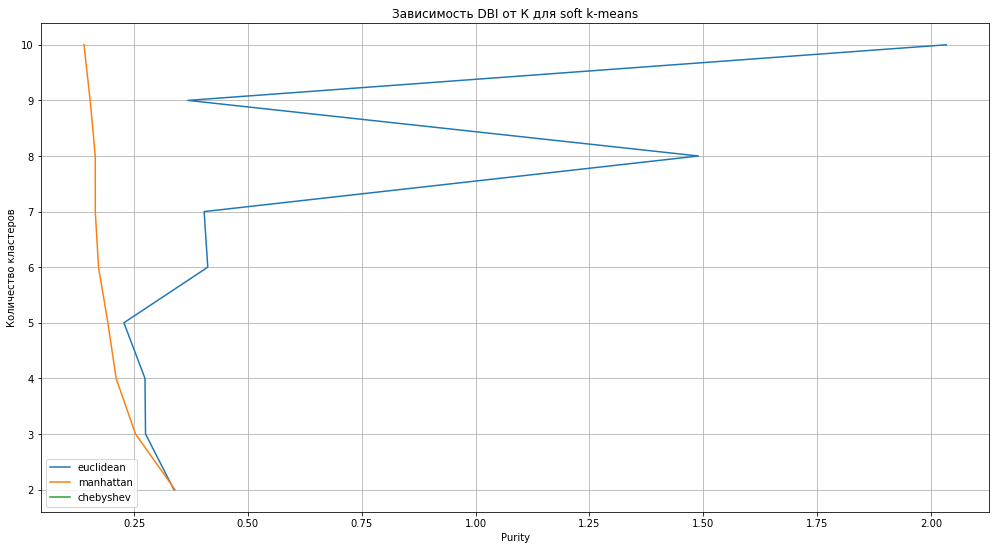

In [84]:
plt.figure(figsize=(17, 9))
plt.title("Зависимость DBI от К для soft k-means") 
plt.xlabel("Purity") 
plt.ylabel("Количество кластеров") 
plt.grid()      
plt.plot(dfskm.loc[dfskm["Dist metric"] == "euclidean", "DBI"], dfskm.loc[dfskm["Dist metric"] == "euclidean", "Nums of clusters"], label="euclidean")
plt.plot(dfskm.loc[dfskm["Dist metric"] == "manhattan", "DBI"], dfskm.loc[dfskm["Dist metric"] == "manhattan", "Nums of clusters"], label="manhattan")
plt.plot(dfskm.loc[dfskm["Dist metric"] == "chebyshev", "DBI"], dfskm.loc[dfskm["Dist metric"] == "chebyshev", "Nums of clusters"], label="chebyshev")
plt.legend()

### Визуализация лучшей модели кластеризации.

**Находим две самых лучших модели кластеризации для *k-means* и *soft k-means* из уже созданных DataFrame**

In [85]:
best_pred_km = np.array(list(sorted_df_k_means.head(1)["labels"]), copy=False)
mask_k_means = np.zeros_like(mask)
for (y, x), pred in zip(OP, best_pred_km[0]):
    mask_k_means[y,x] = pred

Text(0.5, 1.0, 'Best clusterization k-means')

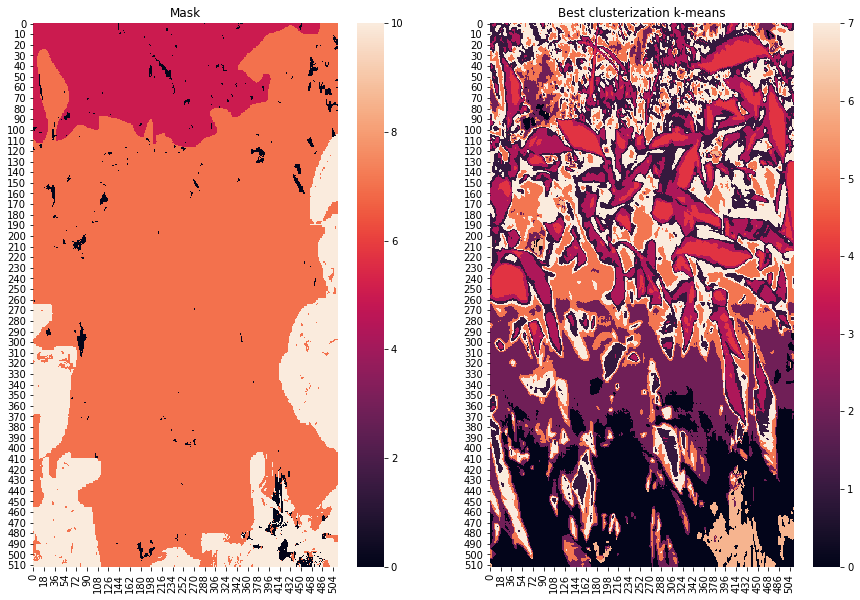

In [86]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(mask_k_means, ax=ax2)
ax1.set_title('Mask')
ax2.set_title('Best clusterization k-means')

In [87]:
best_pred_skm = np.array(list(sorted_df_soft_k_means.head(1)["labels"]), copy=False)
mask_soft_k_means = np.zeros_like(mask)
for (y, x), pred in zip(OP, best_pred_skm[0]):
    mask_soft_k_means[y,x] = pred

Text(0.5, 1.0, 'Best clusterization soft k-means')

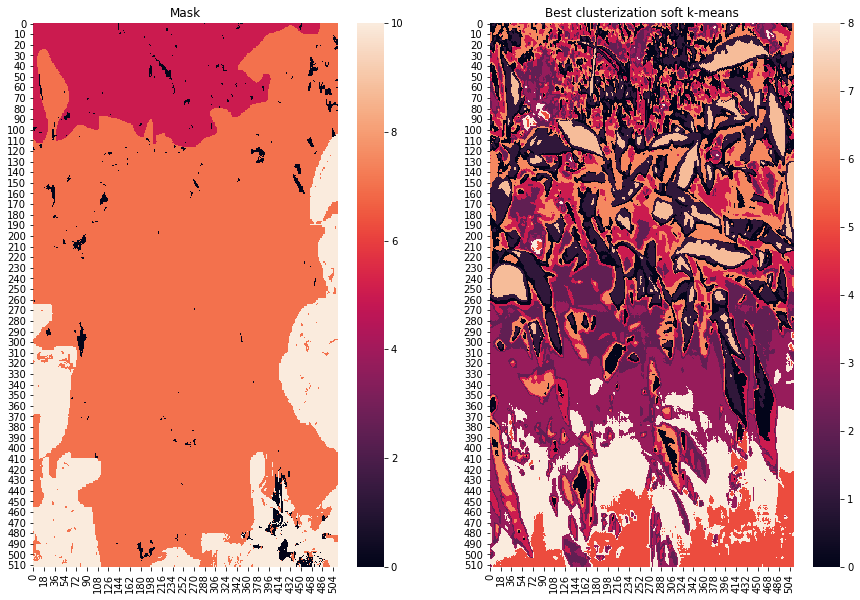

In [88]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(mask_soft_k_means, ax=ax2)
ax1.set_title('Mask')
ax2.set_title('Best clusterization soft k-means')